In [58]:
import tables as tb
from matplotlib import pyplot as plt
import numpy as np

FILE_NAME = 'file.h5' # TODO: Replace this
file = tb.open_file(FILE_NAME, 'r')

file

File(filename=file.h5, title=np.str_(''), mode='r', root_uep='/', filters=Filters(complevel=0, shuffle=False, bitshuffle=False, fletcher32=False, least_significant_digit=None))
/ (RootGroup) np.str_('')
/rx_group (Group) np.str_('')
/rx_group/antenna0 (Table(np.int64(307200),)) np.str_('')
  description := {
  "timestamp": UInt64Col(shape=(), dflt=np.uint64(0), pos=0),
  "count": Int32Col(shape=(), dflt=np.int32(0), pos=1),
  "real": Int16Col(shape=(), dflt=np.int16(0), pos=2),
  "im": Int16Col(shape=(), dflt=np.int16(0), pos=3)}
  byteorder := 'little'
  chunkshape := (np.int64(4096),)
/tx_group (Group) np.str_('')
/tx_group/antenna0 (Table(np.int64(289984),)) np.str_('')
  description := {
  "timestamp": UInt64Col(shape=(), dflt=np.uint64(0), pos=0),
  "count": Int32Col(shape=(), dflt=np.int32(0), pos=1),
  "real": Int16Col(shape=(), dflt=np.int16(0), pos=2),
  "im": Int16Col(shape=(), dflt=np.int16(0), pos=3)}
  byteorder := 'little'
  chunkshape := (np.int64(4096),)

In [59]:
# Check README.md for file structure.
# Group data into dict(timestamp: [complex])
def GroupTable(data) -> dict:
    out = {}
    for row in data.iterrows():
        if row['timestamp'] not in out:
            # First sort by count
            records = {record['count'] : complex(record['real'], record['im']) \
                    for record in data.iterrows() if record['timestamp'] == row['timestamp']}\
            
            records = dict(sorted(records.items()))

            out[row['timestamp']] = list(records.values())
    
    # Sort by key (timestamp)
    out = dict(sorted(out.items()))
    return out

In [60]:
# Extract RX and TX data (only using antenna0)
# Timestamp: list[complex numbers]
rx_data = GroupTable(file.root.rx_group.antenna0)
tx_data = GroupTable(file.root.tx_group.antenna0)

rx: [38860800 38891520 38922240 38952960 38983680 39014400 39045120 39075840
 39106560 39137280]
tx: [39045120 39075840 39106560 39137280 39168000 39198720 39229440 39321280
 39352320 39383040]


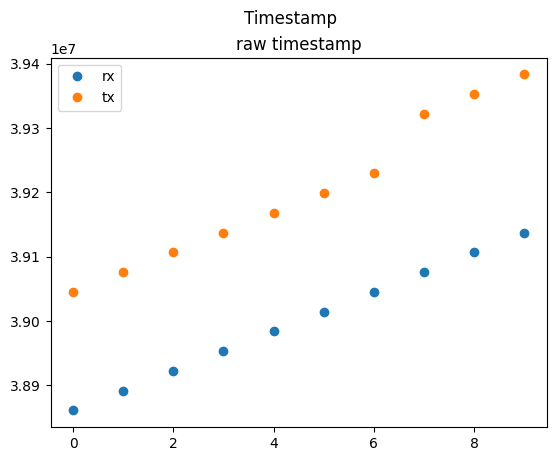

In [61]:
# Plot the timestamps
rx_timestamp_list = np.array(list(rx_data.keys()))
tx_timestamp_list = np.array(list(tx_data.keys()))
#timestamp_offset = np.min(abs(rx_timestamp_list - tx_timestamp_list))

print(f'rx: {rx_timestamp_list}')
print(f'tx: {tx_timestamp_list}')
#print(f'smallest difference: {timestamp_offset}')


fig, axes = plt.subplots()
fig.suptitle("Timestamp")

# Show raw timestamp
axes.set_title('raw timestamp')
axes.plot(rx_data.keys(), 'o', label= 'rx')
axes.plot(tx_data.keys(), 'o', label= 'tx')
axes.legend()

# # Offset rx or tx by the offset. Subtract offset from the set with larger timestamps.
# if rx_timestamp_list[0] > tx_timestamp_list[0]:
#     rx_timestamp_list -= timestamp_offset
#     # Update the dictionary accordingly
#     rx_data = {k - timestamp_offset : v for k, v in rx_data.items()}
# else:
#     tx_timestamp_list -= timestamp_offset
#     tx_data = {k - timestamp_offset : v for k, v in tx_data.items()}

# axes[1].set_title('adjusted timestamp')
# axes[1].plot(rx_timestamp_list, 'o', label= 'rx')
# axes[1].plot(tx_timestamp_list, 'o', label= 'tx')
# axes[0].legend()

In [62]:
# Extract samples with matching timestamps, tuple(rx, tx) of list:
matching_samples = []
tol_offset = 600 # TODO Determine

for timestamp, samples, i in zip(rx_data.keys(), rx_data.values(), range(len(rx_data.keys()))):
    tx_index = np.argmin(np.abs(timestamp - np.array(list(tx_data.keys()))))
    diff = abs(list(tx_data.keys())[tx_index] - timestamp)

    if diff < tol_offset:
        print(f'Match for rx at {i}: {tx_index}')
        matching_samples.append((samples, list(tx_data.values())[tx_index]))
    else:
        print(f'No match for rx at {i}. Diff: {diff}')


# for rx, tx, i in zip(rx_data.items(), tx_data.items(), range(len(tx_data))):
#     if abs(rx[0] - tx[0]) < tol_offset:
#         print(f'Matching samples at {i}')

#         rx_samples_ctr = len(rx[1])
#         tx_samples_ctr = len(tx[1])
#         diff = rx_samples_ctr - tx_samples_ctr
#         print(f'    no. rx samples: {rx_samples_ctr}; no. tx samples: {tx_samples_ctr}')

#         r_list = list(rx[1])
#         t_list = list(tx[1])

#         if diff < 0:
#             print(f'padding {abs(diff)} trailing 0s to rx to match the size ')
#             r_list += [0] * abs(diff)
#         elif diff > 0:
#             print(f'padding {abs(diff)} trailing 0s to tx to match the size ')
#             t_list += [0] * abs(diff)

#         matching_samples.append((r_list, t_list))


No match for rx at 0. Diff: 184320
No match for rx at 1. Diff: 153600
No match for rx at 2. Diff: 122880
No match for rx at 3. Diff: 92160
No match for rx at 4. Diff: 61440
No match for rx at 5. Diff: 30720
Match for rx at 6: 0
Match for rx at 7: 1
Match for rx at 8: 2
Match for rx at 9: 3


In [ ]:
col_out = []
for (rx, tx) in matching_samples:
    col_out.append(np.correlate(rx, tx, mode= 'full')) # TODO: Try different modes (valid, full, same)

print(col_out)

[array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
      shape=(61439,)), array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
      shape=(61439,)), array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
      shape=(61439,)), array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
      shape=(61439,))]


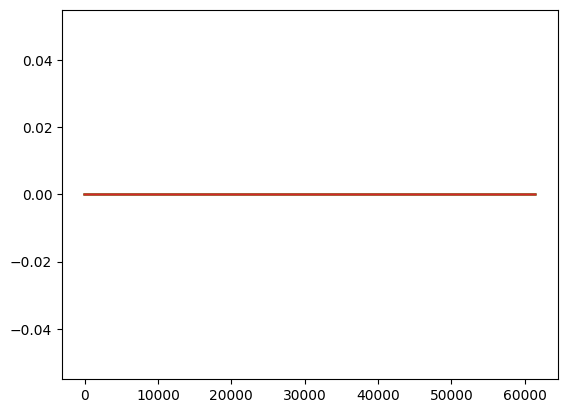

In [64]:
fig, ax = plt.subplots()
for out in col_out:
    ax.plot(abs(out))